# Skip Connections in ResNets: Importance and Impact

Skip connections, also referred to as residual connections, are a fundamental architectural innovation in ResNet models. Introduced to tackle the challenges associated with training deep neural networks, particularly the vanishing gradient problem, they have significantly advanced the design and training of deep learning architectures. Here's a closer look at their importance:

## 1. Mitigating Vanishing Gradients
Training very deep neural networks often leads to the vanishing gradient problem, where gradients diminish as they are propagated backward through the layers. This makes it difficult for the network to update its parameters effectively, leading to stalled or slow training. Skip connections provide direct pathways for gradients to flow backward without passing through all intermediate layers, reducing the likelihood of vanishing gradients. This mechanism ensures that even the deepest networks can retain robust gradient signals during training.

## 2. Facilitating Extremely Deep Networks
Prior to the introduction of ResNets, training networks with over 100 layers was practically infeasible due to optimization challenges. Skip connections revolutionized this by enabling the construction and efficient training of extremely deep architectures, allowing networks to achieve state-of-the-art performance in tasks ranging from image recognition to natural language processing.

## 3. Simplifying Optimization
Skip connections transform the optimization landscape by creating residual learning pathways. Instead of directly mapping inputs to outputs, the network learns residual functions, which are often easier to optimize. This greatly aids algorithms like stochastic gradient descent (SGD) in converging to effective solutions more quickly.

## 4. Enhancing Generalization
By allowing information to flow across both shallow and deep layers, skip connections enable the network to capture a rich hierarchy of features. Shallow layers focus on fine-grained details, while deeper layers extract high-level abstractions. This complementary learning improves the model's ability to generalize to unseen data.



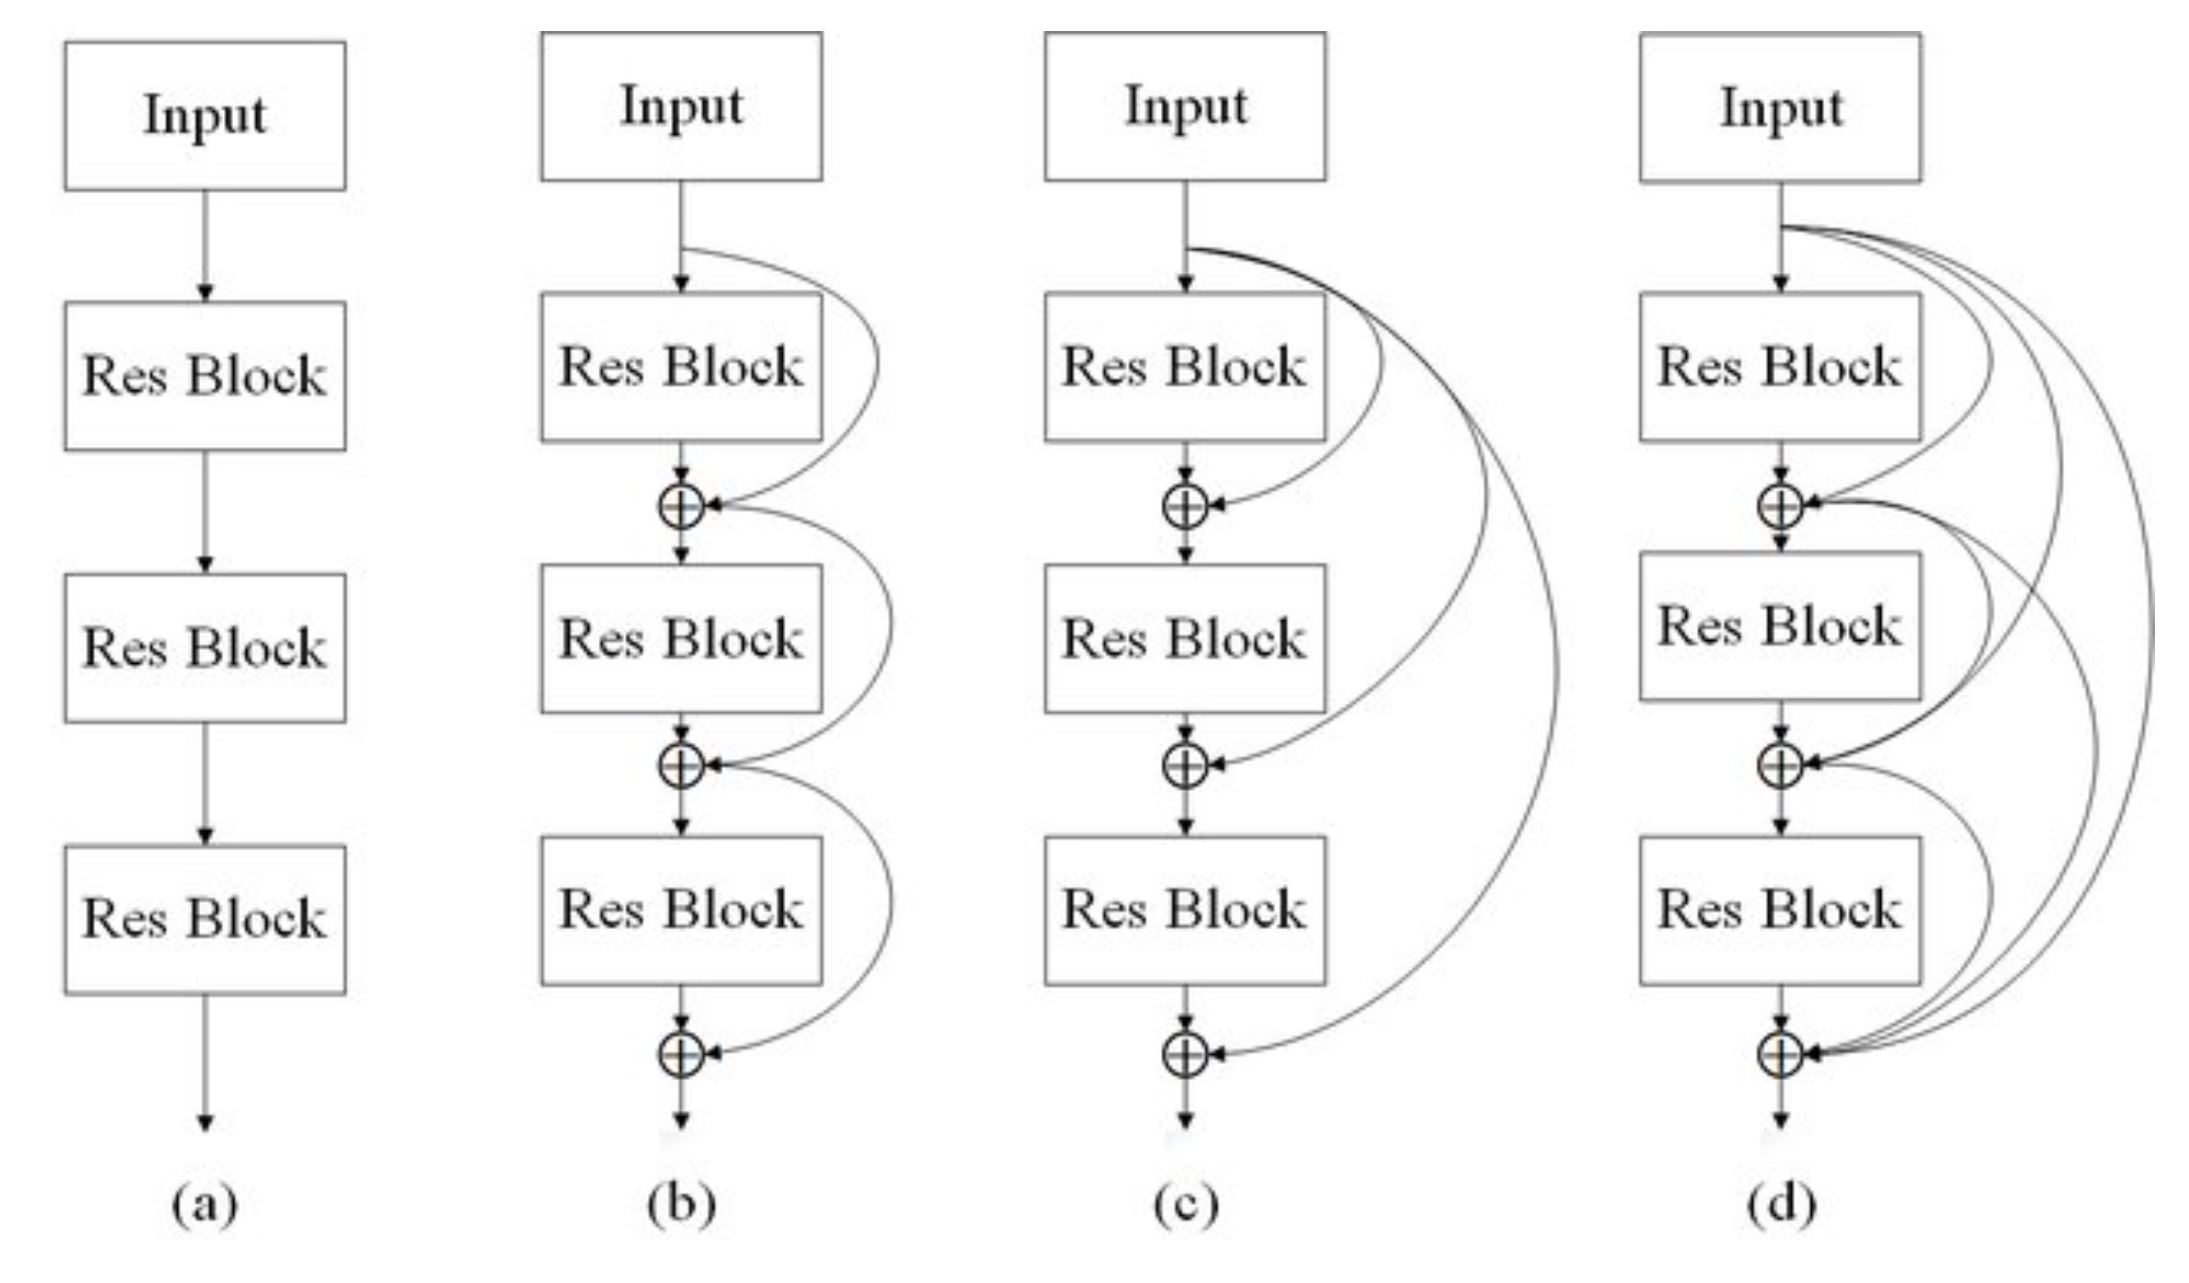



Mini-batch related questions: https://github.com/FrancescoSaverioZuppichini/Tensorflow-Dataset-Tutorial/blob/master/dataset_tutorial.ipynb

# What is the Difference Between Steps and Epochs?

In machine learning, understanding the distinction between **steps** and **epochs** is essential for configuring and interpreting model training. While they are both metrics used to track progress during training, they represent different aspects of the process:

## 1. Epochs
An **epoch** refers to one complete pass of the entire training dataset through the model. For example, if your dataset contains 10,000 images, one epoch means that all 10,000 images have been presented to the model exactly once, potentially divided into smaller batches for processing efficiency.

## 2. Steps
A **step** represents a single forward and backward pass of one batch of data through the model. The total number of steps required to complete one epoch depends on the size of the dataset and the chosen batch size.

## Example for Clarity

Imagine you have a training dataset with **10,000 images** and set the **batch size** to **100**:  
- **Epochs:** Each epoch consists of \( \frac{10,000}{100} = 100 \) steps, meaning the model will process 100 batches of 100 images each to complete one epoch.
- **Steps:** If you set the number of steps to **1000** with a batch size of **10**, the model will process \( 1000 \times 10 = 10,000 \) images, equivalent to seeing the entire dataset once (but not necessarily in sequence).

## Key Distinction
- **Epochs** measure how many times the model has seen the full dataset.
- **Steps** measure how many batches the model has processed.  
The relationship between steps and epochs depends on the batch size and the size of the dataset. For a dataset with \( N \) samples, batch size \( B \), and \( S \) steps:
\[
\text{Steps per epoch} = \frac{N}{B}, \quad \text{and total epochs = } \frac{\text{Total steps}}{\text{Steps per epoch}}.
\]

## Practical Consideration
Choosing the right number of steps and epochs involves a balance:  
- More epochs allow the model to learn more, but excessive training may lead to overfitting.
- The number of steps defines how often model weights are updated per epoch and affects computational efficiency.

Understanding these concepts helps tailor the training process to optimize performance and resource usage.


# Transfer Learning (or Green Deep Learning!)

## What is Transfer Learning?

**Transfer learning (TL)** is a machine learning technique that leverages knowledge gained from solving one problem and applies it to a different but related problem. 

The process typically starts with a **pre-trained model**—a saved network trained on a large dataset, often for tasks like large-scale image classification. This pre-trained model can either be used "as is" or customized for a specific task through transfer learning.

## Why Use Transfer Learning?

Transfer learning offers several key advantages:

- **Minimized Training Time**: Reduces the amount of data and computation needed to achieve high performance.
- **Lower Emissions**: Less computational effort leads to reduced energy consumption and environmental impact.
- **More Powerful Feature Extractors**: Pre-trained models already capture meaningful patterns from large datasets, making them effective starting points for new tasks.

![Compute Diagram](https://ekamperi.github.io/images/compute_diagram.png)  
[Source: NVIDIA Blog](https://developer.nvidia.com/blog/training-bert-with-gpus/)

![Training Process](https://ekamperi.github.io/images/nvidia_training.jpg)  
[Source: NVIDIA Blog](https://developer.nvidia.com/blog/training-bert-with-gpus/)

![Footprint Comparison](https://ekamperi.github.io/images/footprint_comparison.png)

## Cost of Training Large Models

Training large-scale models can be expensive. Below are the estimated costs based on model size:  
- **110 million parameters**: $2,500 – $50,000  
- **340 million parameters**: $10,000 – $200,000  
- **1.5 billion parameters**: $80,000 – $1.6 million  

_Source: SyncedReview.com_

## Customizing a Pretrained Model

Here, we will explore two common methods for adapting a pretrained model to a specific task:

1. **Feature Extraction**  
   Use the pre-trained model as a feature extractor by freezing its weights and adding new layers for your specific task (covered in the last tutorial).  
   
2. **Fine-Tuning**  
   Unfreeze some or all of the model's weights and retrain them on your dataset to better align with the task at hand.

---

Let’s dive into these approaches and see how transfer learning can be implemented in practice!


In [1]:
!pip install torch torchvision torchaudio

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

In [3]:
import os
import zipfile
from urllib.request import urlretrieve

# Downloading the data
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
os.makedirs('./data', exist_ok=True)
path_to_zip = os.path.join('./data', 'cats_and_dogs.zip')

# Download the file
print("Downloading the dataset...")
urlretrieve(_URL, path_to_zip)

# Extract the zip file
print("Extracting the dataset...")
with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall('./data/')

# Set paths
PATH = os.path.join('./data', 'cats_and_dogs_filtered')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

print("Dataset is ready!")


Extracting the dataset...
Dataset is ready!


In [4]:
# Define data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create datasets
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(validation_dir, transform=data_transforms['val'])

# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

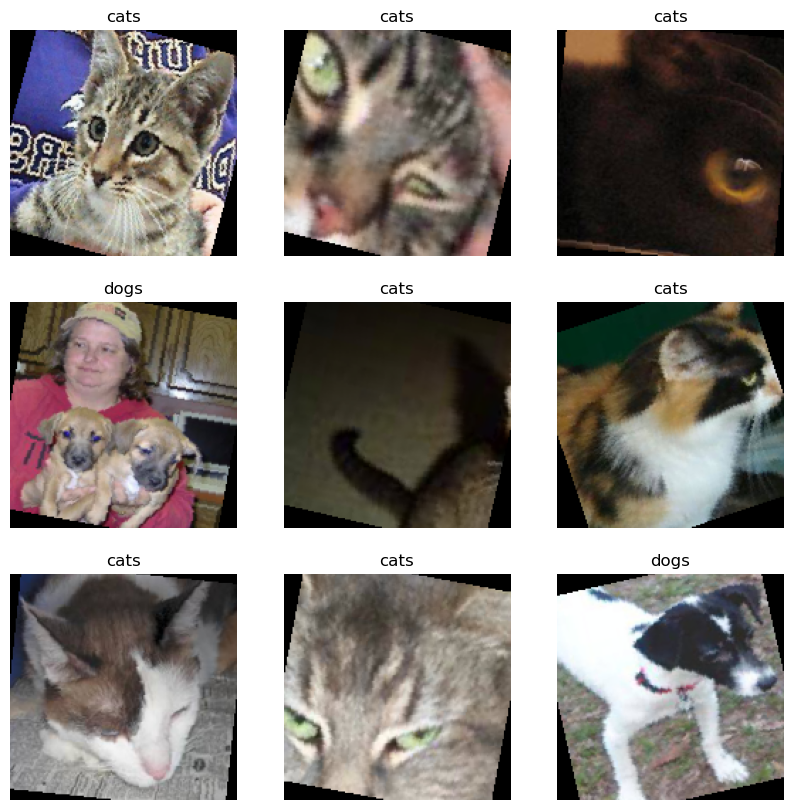

In [5]:
class_names = train_dataset.classes

# Define a function to reverse normalization
def denormalize(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image.numpy().transpose((1, 2, 0))
    image = std * image + mean
    return np.clip(image, 0, 1)

# Visualize some images
plt.figure(figsize=(10, 10))
for images, labels in train_loader:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(denormalize(images[i]))
        plt.title(class_names[labels[i].item()])
        plt.axis("off")
    break

In [6]:
# Split validation dataset into validation and test datasets
total_val = len(val_dataset)
test_size = total_val // 5
val_size = total_val - test_size
val_dataset, test_dataset = torch.utils.data.random_split(val_dataset, [val_size, test_size])

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
print(f'Number of validation batches: {len(val_loader)}')
print(f'Number of test batches: {len(test_loader)}')

Number of validation batches: 25
Number of test batches: 7


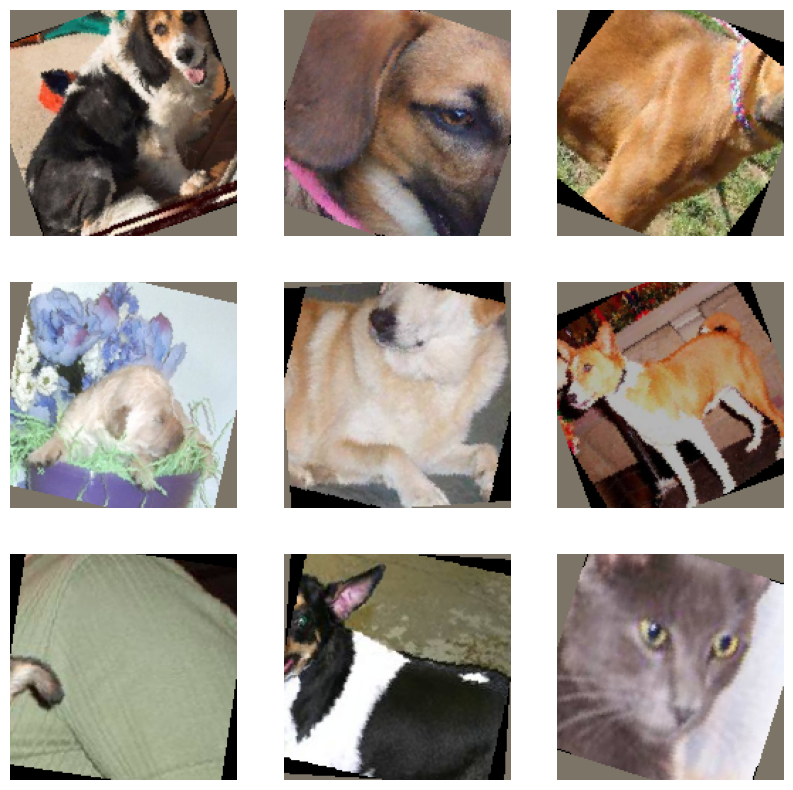

In [8]:
#Let's repeatedly apply these layers to the same image and see the result.

# Define data augmentation for training
data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20)
])

for images, _ in train_loader:
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(images[i])
        plt.imshow(denormalize(augmented_image))
        plt.axis('off')
    break

In [9]:
# Load pre-trained model
base_model = models.mobilenet_v2(pretrained=True)
base_model.features.requires_grad = False

/home/ubuntu/data/anaconda3/envs/mat/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/data/anaconda3/envs/mat/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
image_batch, label_batch = next(iter(train_loader))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# 32 = batch size

torch.Size([32, 1000])


image_batch, label_batch = next(iter(train_dataset)): Obtain a single batch of data (both images and their corresponding labels) from the train_dataset. It assumes that you have an iterator for the dataset (achieved through iter(train_dataset)), and it assigns the batch of images to image_batch and the batch of labels to label_batch.

feature_batch = base_model(image_batch): In this line, you're passing the image_batch through a pre-trained base model. The base_model is likely a pre-trained deep neural network (e.g., a convolutional neural network like VGG, ResNet, etc.) that has been loaded and configured for feature extraction. By passing the images through this model, you're obtaining a batch of feature vectors for the images. These feature vectors represent the learned high-level representations of the images within the neural network's layers.

print(feature_batch.shape): print the shape of the feature_batch. This will give you information about the dimensions of the feature vectors produced by the base model for the current batch of images. The shape will typically be in the format (batch_size, num_features), where batch_size is the number of images in the batch, and num_features is the number of features extracted by the base model for each image.

In [11]:
# Let's take a look at the base model architecture
print(base_model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API.

In [12]:
# Modify the model for binary classification
num_features = base_model.last_channel
model = torch.nn.Sequential(
    base_model.features,
    torch.nn.AdaptiveAvgPool2d(1),
    torch.nn.Flatten(),
    torch.nn.Linear(num_features, 1)
)

Compile the model before training it

In [13]:
# Define optimizer, loss function, and metrics
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

In [14]:
print(model)

Sequential(
  (0): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, m

Note: The 2.5M parameters in MobileNet are frozen, but there are 1.2K trainable parameters in the Dense layer!

Let's see the validation performance before training!

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_acc, val_acc = [], []
    train_loss, val_loss = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            labels = labels.float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = torch.round(torch.sigmoid(outputs))
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = correct_train / total_train
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                labels = labels.float().unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                preds = torch.round(torch.sigmoid(outputs))
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        epoch_val_loss = running_val_loss / len(val_loader)
        epoch_val_acc = correct_val / total_val
        val_loss.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

    return train_loss, train_acc, val_loss, val_acc

train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 1/10, Train Loss: 0.2847, Train Acc: 0.8700, Val Loss: 0.0989, Val Acc: 0.9637
Epoch 2/10, Train Loss: 0.1984, Train Acc: 0.9100, Val Loss: 0.0999, Val Acc: 0.9513
Epoch 3/10, Train Loss: 0.1808, Train Acc: 0.9225, Val Loss: 0.0837, Val Acc: 0.9688
Epoch 4/10, Train Loss: 0.1474, Train Acc: 0.9410, Val Loss: 0.0735, Val Acc: 0.9688
Epoch 5/10, Train Loss: 0.1488, Train Acc: 0.9335, Val Loss: 0.0813, Val Acc: 0.9650
Epoch 6/10, Train Loss: 0.1359, Train Acc: 0.9395, Val Loss: 0.0870, Val Acc: 0.9675
Epoch 7/10, Train Loss: 0.1357, Train Acc: 0.9395, Val Loss: 0.1325, Val Acc: 0.9537
Epoch 8/10, Train Loss: 0.1256, Train Acc: 0.9465, Val Loss: 0.0994, Val Acc: 0.9650
Epoch 9/10, Train Loss: 0.1226, Train Acc: 0.9455, Val Loss: 0.0901, Val Acc: 0.9625
Epoch 10/10, Train Loss: 0.1155, Train Acc: 0.9480, Val Loss: 0.0844, Val Acc: 0.9650


Let's now look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor!

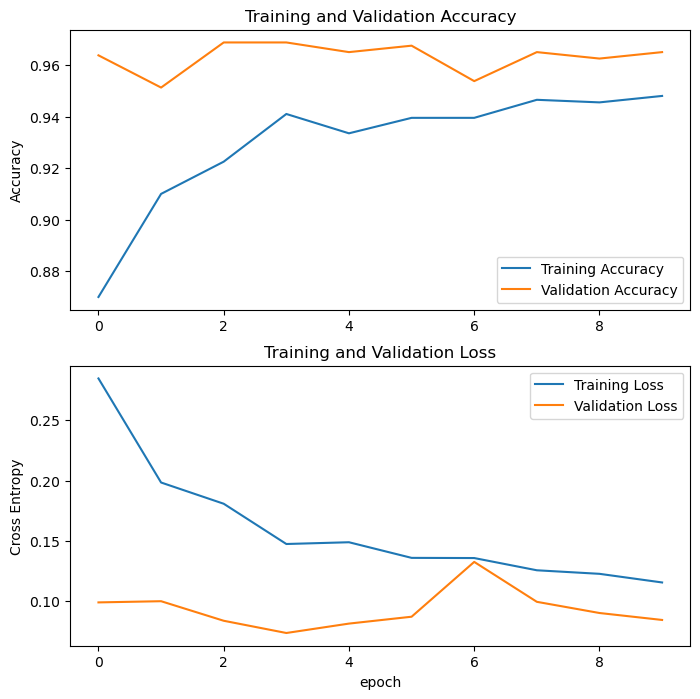

In [16]:
# Visualize training progress
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine-tuning!

In the feature extraction experiment, you were only training a few layers on top (classification layers) of an MobileNet V2 base model. The weights of the (CNN part)pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added.


Let's un-freeze the top layers of the model!

In [17]:
# Fine-tune from this layer onwards
fine_tune_at = 140

# Freeze all the layers before the `fine_tune_at` layer
layer_num = 0
for param in base_model.features.parameters():
    if layer_num < fine_tune_at:
        param.requires_grad = False
    else:
        param.requires_grad = True
    layer_num += 1

In [18]:
model2 = torch.nn.Sequential(
    base_model.features,
    torch.nn.AdaptiveAvgPool2d(1),
    torch.nn.Flatten(),
    torch.nn.Linear(num_features, 1)
)

In [19]:
# Define optimizer, loss function, and metrics
optimizer = torch.optim.RMSprop(filter(lambda p: p.requires_grad, model2.parameters()), lr=1e-5)
criterion = torch.nn.BCEWithLogitsLoss()

Note: number of trainable paramters now jumped to ~1.

What's the none-trainable prameters?
Other paramters associated with the model:
- Input shape
- The number of hidden layers itself
- Nodes on each hidden layer
- Statistics in BatchNormalization layers and other operation layers
- any paramter not updated by gradient descent!

In [20]:
train_loss, train_acc, val_loss, val_acc = train_model(model2, train_loader, val_loader, criterion, optimizer)


Epoch 1/10, Train Loss: 0.2627, Train Acc: 0.9295, Val Loss: 0.1188, Val Acc: 0.9688
Epoch 2/10, Train Loss: 0.1544, Train Acc: 0.9595, Val Loss: 0.0956, Val Acc: 0.9650
Epoch 3/10, Train Loss: 0.1287, Train Acc: 0.9560, Val Loss: 0.0838, Val Acc: 0.9663
Epoch 4/10, Train Loss: 0.1233, Train Acc: 0.9575, Val Loss: 0.0783, Val Acc: 0.9675
Epoch 5/10, Train Loss: 0.1113, Train Acc: 0.9520, Val Loss: 0.0781, Val Acc: 0.9675
Epoch 6/10, Train Loss: 0.1124, Train Acc: 0.9525, Val Loss: 0.0756, Val Acc: 0.9688
Epoch 7/10, Train Loss: 0.1123, Train Acc: 0.9595, Val Loss: 0.0740, Val Acc: 0.9663
Epoch 8/10, Train Loss: 0.1018, Train Acc: 0.9615, Val Loss: 0.0717, Val Acc: 0.9663
Epoch 9/10, Train Loss: 0.1131, Train Acc: 0.9600, Val Loss: 0.0741, Val Acc: 0.9675
Epoch 10/10, Train Loss: 0.1073, Train Acc: 0.9555, Val Loss: 0.0708, Val Acc: 0.9650


We see the difference now!

Let's visulize the before and after fine-tuning perfromance!

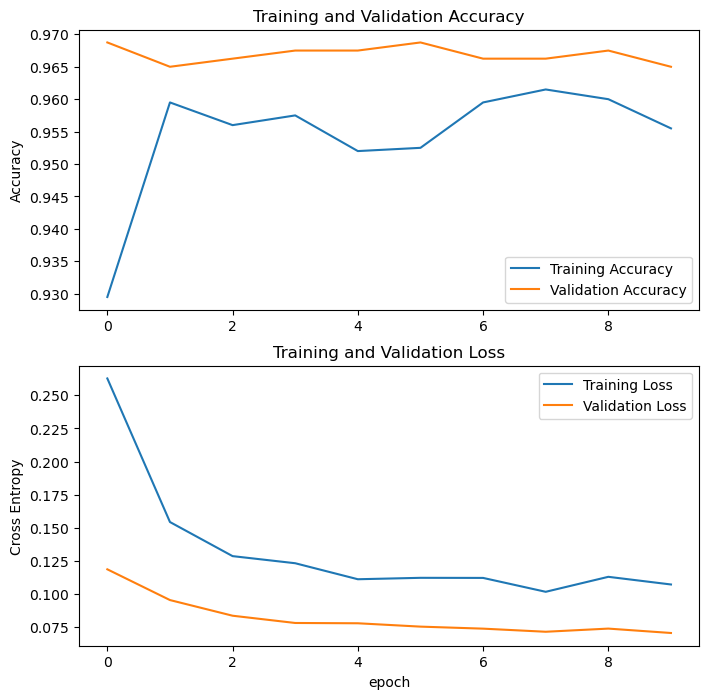

In [21]:
# Visualize training progress
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Finaly let's look at the test performance

In [22]:
# Evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total}%")

# Evaluate on validation and test sets
evaluate_model(model2, test_loader)

Accuracy: 51.5%


The model is now ready for predicting if your pet is a cat or dog.

Predictions:
 [0 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1]
Labels:
 [0 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1]


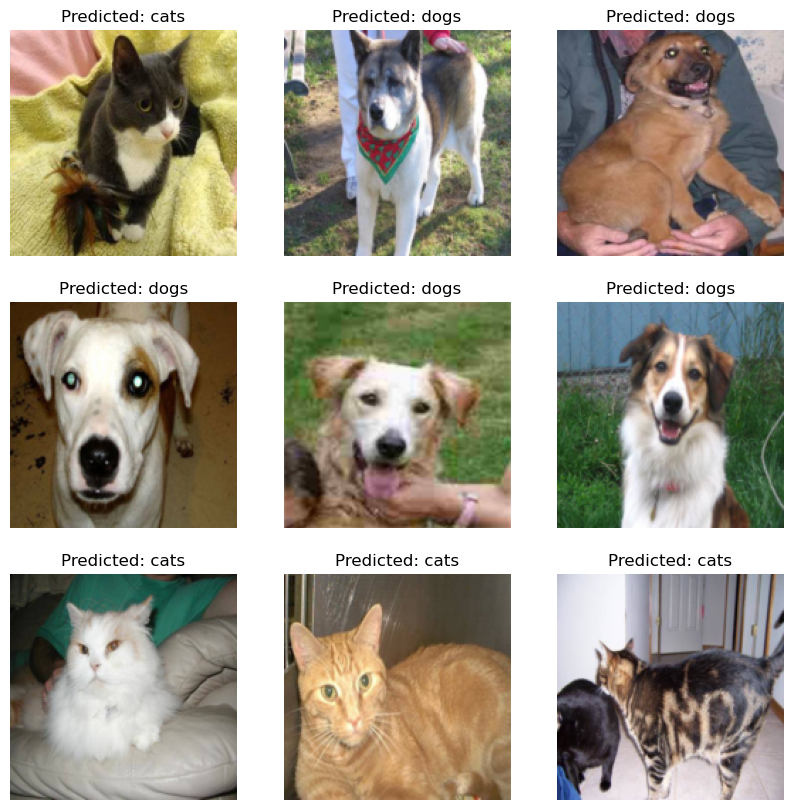

In [23]:
# Retrieve a batch of images from the test set
data_iter = iter(test_loader)
image_batch, label_batch = next(data_iter)

# Make predictions
model2.eval()
with torch.no_grad():
    logits = model2(image_batch)
    predictions = torch.sigmoid(logits).flatten()

# Apply threshold since our model returns logits
predictions = (predictions >= 0.5).int()

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch.numpy())

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(denormalize(image_batch[i]))
    plt.title(f"Predicted: {class_names[predictions[i].item()]}")
    plt.axis("off")

# Part 2: Transfer learning with Torch Hub

Let's demonstrate its use!

In [26]:
# Setup
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import requests
from torch import nn


Let's start with ImageNet by using a pretrained classifer model to take an image and predict what it's an image of - no training required!

In [28]:
# Define image shape and model
IMAGE_SHAPE = (224, 224)
# model = models.efficientnet_b0(pretrained=True)
model_url = "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth"
state_dict = torch.hub.load_state_dict_from_url(model_url, map_location=torch.device('cpu'))
model = models.efficientnet_b0()
model.load_state_dict(state_dict)
model.eval()

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 379MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Download a single image to apply the model on

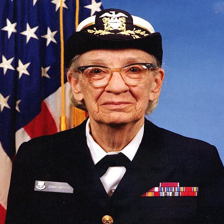

In [29]:
# Load and preprocess the image
grace_hopper_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg'
grace_hopper = Image.open(requests.get(grace_hopper_url, stream=True).raw).resize(IMAGE_SHAPE)

display(grace_hopper)


In [30]:
# Manual normalization
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMAGE_SHAPE),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
grace_hopper_tensor = preprocess(grace_hopper).unsqueeze(0)

grace_hopper_tensor.shape

torch.Size([1, 3, 224, 224])

In [31]:
# Add a batch dimension, and pass the image to the model
with torch.no_grad():
    result = model(grace_hopper_tensor)
result.shape

torch.Size([1, 1000])

In [32]:
# Get the predicted class
predicted_class = torch.argmax(result[0], dim=-1).item() + 1
predicted_class

653

In [33]:
# Decode predictions using ImageNet labels
labels_url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
imagenet_labels = requests.get(labels_url).text.splitlines()

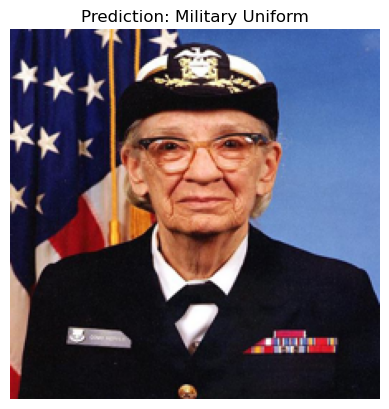

In [34]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Full example
What if you want to train  transfer learninga classifier for a dataset with different classes?

In [35]:
# Let's download the data
data_root = datasets.utils.download_and_extract_archive(
    url='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    download_root='./data',
    extract_root='./data')

 11%|█         | 25198592/228813984 [00:00<00:02, 92515701.09it/s]

100%|██████████| 228813984/228813984 [00:01<00:00, 178389377.84it/s]


Extracting ./data/flower_photos.tgz to ./data


In [36]:
# Let's load this data into our model using images off disk using ImageFolder.
batch_size = 32
img_height = 224
img_width = 224

transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(root='./data/flower_photos', transform=transform)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [37]:
# We have five different flower classes
class_names = train_ds.classes
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [38]:
# Let's check some images
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [39]:
# Run classifier
# NOTE: It takes some time!
with torch.no_grad():
    data_batch, _ = next(iter(train_loader))
    result_batch = model(data_batch)

In [40]:
predicted_class_names = [imagenet_labels[torch.argmax(output).item()] for output in result_batch]
predicted_class_names

['vacuum',
 'ringlet',
 'pop bottle',
 'rapeseed',
 'bee',
 'rapeseed',
 'Windsor tie',
 'acorn',
 'rapeseed',
 'monarch',
 'pop bottle',
 'monarch',
 'hamster',
 'rapeseed',
 'bell pepper',
 'notebook',
 'rapeseed',
 'pickelhaube',
 'rapeseed',
 'rapeseed',
 'flute',
 'orange',
 'acorn',
 'fly',
 'pop bottle',
 'orange',
 'pickelhaube',
 'pickelhaube',
 'starfish',
 'mashed potato',
 'rapeseed',
 'rapeseed']

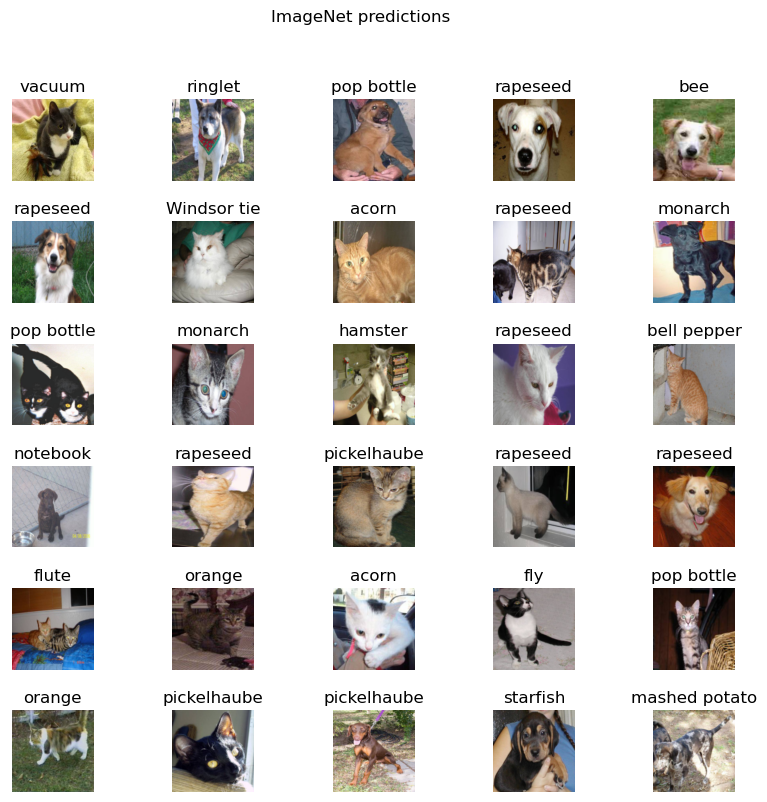

In [41]:
# Now check how these predictions line up with images
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(denormalize(image_batch[n]))
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [42]:
# Load feature extractor model
feature_extractor_model = models.mobilenet_v2(pretrained=True)
feature_extractor_model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [43]:
# It returns a 1280-length vector of features for each image:
feature_extractor_layer = nn.Sequential(*list(feature_extractor_model.children())[:-1])


In [44]:
with torch.no_grad():
    feature_batch = feature_extractor_layer(data_batch)


In [45]:
# Let's wrap the model layer in a new model, and add a new classification layer!
num_classes = len(class_names)

model = nn.Sequential(
    feature_extractor_layer,
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(1280, num_classes)
)

print(model)

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1

Note: we are freezing feature extraction layers here too!

In [46]:
# Predictions
with torch.no_grad():
    predictions = model(data_batch)

In [47]:
predictions.shape

torch.Size([32, 5])

In [48]:
# Let's train the model
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [49]:
# Helper functions to visualize the training progress
class CollectBatchStats:
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, loss, acc):
        self.batch_losses.append(loss)
        self.batch_acc.append(acc)

batch_stats_callback = CollectBatchStats()

# Training loop
epochs = 2
for epoch in range(epochs):
    model.train()
    for batch, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        acc = (preds == labels).float().mean().item()
        
        # Output loss and accuracy during training
        print(f"Epoch {epoch+1}, Batch {batch+1}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")

        batch_stats_callback.on_train_batch_end(loss.item(), acc)


Epoch 1, Batch 1, Loss: 1.7158, Accuracy: 0.1250
Epoch 1, Batch 2, Loss: 1.0205, Accuracy: 0.6250
Epoch 1, Batch 3, Loss: 0.7076, Accuracy: 0.7500
Epoch 1, Batch 4, Loss: 0.5059, Accuracy: 0.8125
Epoch 1, Batch 5, Loss: 0.9459, Accuracy: 0.6875
Epoch 1, Batch 6, Loss: 0.9016, Accuracy: 0.6875
Epoch 1, Batch 7, Loss: 0.7083, Accuracy: 0.7812
Epoch 1, Batch 8, Loss: 0.4620, Accuracy: 0.8438
Epoch 1, Batch 9, Loss: 0.6734, Accuracy: 0.8125
Epoch 1, Batch 10, Loss: 0.4729, Accuracy: 0.8125
Epoch 1, Batch 11, Loss: 0.4750, Accuracy: 0.7500
Epoch 1, Batch 12, Loss: 0.9234, Accuracy: 0.8125
Epoch 1, Batch 13, Loss: 0.7687, Accuracy: 0.7812
Epoch 1, Batch 14, Loss: 0.6005, Accuracy: 0.7812
Epoch 1, Batch 15, Loss: 0.5237, Accuracy: 0.8125
Epoch 1, Batch 16, Loss: 0.4981, Accuracy: 0.7812
Epoch 1, Batch 17, Loss: 0.5325, Accuracy: 0.8125
Epoch 1, Batch 18, Loss: 0.6885, Accuracy: 0.7188
Epoch 1, Batch 19, Loss: 0.4219, Accuracy: 0.9062
Epoch 1, Batch 20, Loss: 0.5939, Accuracy: 0.7812
Epoch 1, 

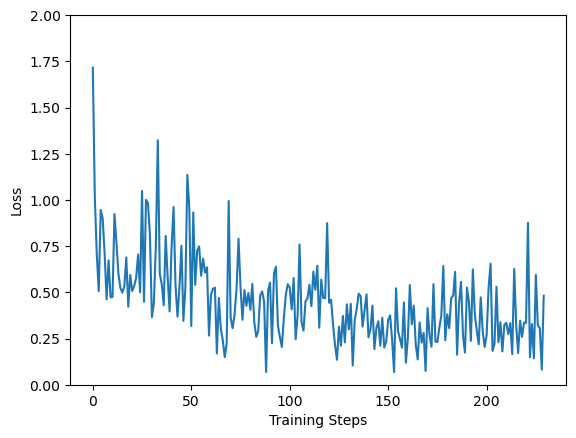

In [50]:
# Let's check the progress on the loss
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

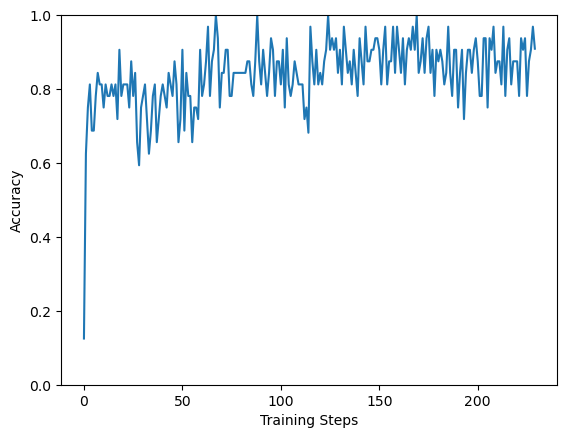

In [51]:
# Let's check the progress on the accuracy
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [52]:
# Let's check the predictions now
with torch.no_grad():
    predicted_batch = model(image_batch)
    predicted_id = torch.argmax(predicted_batch, dim=-1)
    predicted_label_batch = [class_names[i] for i in predicted_id]

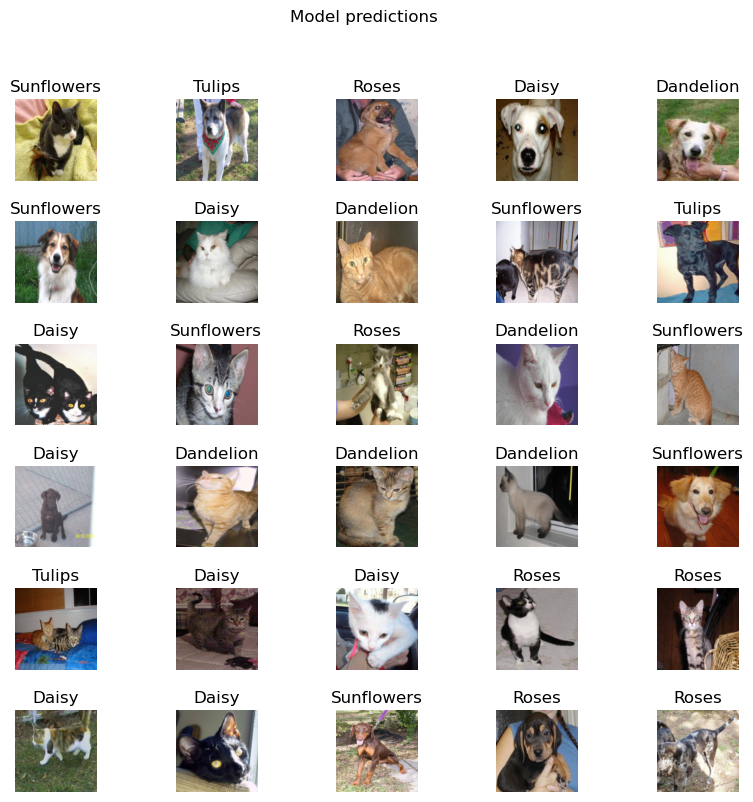

In [53]:
# Plot
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(denormalize(image_batch[n]))
    plt.title(predicted_label_batch[n].title())
    plt.axis('off')
_ = plt.suptitle("Model predictions")